In [1]:
import os
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import shutil as sh
import re
import os
import matplotlib as mpl
from matplotlib.colors import Normalize 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

In [2]:
class calc_BTBT():
    def __init__(self):
        self.R1_list=np.linspace(4.4,4.8,5)
        self.R2_list=np.linspace(0.8,1.3,6)
        self.R3_list=np.array([np.round(r,1) for r in np.linspace(-4.0,4.0,81)])
        self.path='C:\\Users\\youmo\\OSC\\interaction\\BTBT\\'
        self.N=41#0～4Åまでの刻み数

    def calculator(self,path_file):
        with open(path_file,'r') as f:
            lines=f.readlines()
        lines_E=[]
        for line in lines:
            if line.find('E(RB3LYP)')>-1:
                lines_E.append(float(line.split()[4])*627.510)
        E_list=[lines_E[5*i]-lines_E[5*i+1]-lines_E[5*i+2] for i in range(int(len(lines_E)/5))]
        return E_list

##### calc #####

    #とりあえずcsvに全結果まとめる関数
    def make_csv_step1(self,glide_mode,edge_mode):#a,b映進どちらか
        df=pd.DataFrame(columns=['R1','R2','theta','E_t','E_p','E'])
        out_dir=self.path+'step1\\glide='+glide_mode+'\\edge='+edge_mode#outファイルのあるディレクトリ
        for file in os.listdir(out_dir):
            if file[-4:]!='.out' and file[-4:]!='.log':
                continue
            x,R1,y,R2,z,theta=re.split('[_=]', file[:-4])
            E_list=self.calculator(out_dir+'\\'+file)
            if len(E_list)!=2:
                print(file)
            E_t=float(E_list[0]);E_p=float(E_list[1])
            data=pd.Series([R1,R2,theta,E_t,E_p,4*E_t+2*E_p],index=df.columns)
            df=df.append(data,ignore_index=True)
        df_6inter=df.sort_values('theta')
        df_6inter_new=df_6inter.reset_index(drop=True)
        df_6inter_new.to_csv(out_dir+'\\step1.csv',index=False)
        
    def make_csv_step2(self,glide_mode,edge_mode):#a,b映進どちらか
        out_dir=self.path+'step2\\glide='+glide_mode+'\\edge='+edge_mode+'\\'#outファイルのあるディレクトリ
        
        #T,P配置のE-R3依存性を出力
        Et1_list=self.calculator(out_dir+'\\t1.log');Et1_list=np.array(Et1_list)
        Et2_list=self.calculator(out_dir+'\\t2.log');Et2_list=np.array(Et2_list)
        Ep_list=self.calculator(out_dir+'\\p.log');Ep_list=np.array(Ep_list)
        df_t1=pd.DataFrame(columns=['R3_t1','Et1']);df_t2=pd.DataFrame(columns=['R3_t2','Et2']);df_p=pd.DataFrame(columns=['R3_p','Ep'])
        df_t1['R3_t1']=self.R3_list;df_t2['R3_t2']=self.R3_list;df_p['R3_p']=self.R3_list
        df_t1['Et1']=Et1_list;df_t2['Et2']=Et2_list;df_p['Ep']=Ep_list
        df_t1.to_csv(out_dir+'t1.csv',index=False);df_t2.to_csv(out_dir+'t2.csv',index=False);df_p.to_csv(out_dir+'p.csv',index=False)
        
        #R3t,R3pに対するEの2Dマップ作成
        E_inter=np.zeros((2*self.N-1,2*self.N-1))
        for row in range(2*self.N-1):
            for col in range(2*self.N-1):
                if edge_mode=='a':#b平行配置が近い
                    R3_t2=np.round(self.R3_list[col]-self.R3_list[row],1)#t2のR3を計算してみる
                elif edge_mode=='b':#a平行配置が近い
                    R3_t2=np.round(self.R3_list[row]-self.R3_list[col],1)
                if R3_t2<-4 or R3_t2>4:#4以内じゃなきゃだめ
                    continue
                E_inter[row][col]=2*(Ep_list[row]+Et1_list[col]+float(Et2_list[self.R3_list==R3_t2]))
        df_6inter=pd.DataFrame(E_inter,index=self.R3_list,columns=self.R3_list)
        df_6inter.to_csv(out_dir+'6inter.csv')
        
    def make_csv_step3(self,glide_mode,edge_mode):
        #Z=1か2かで分ける。
        df_1=pd.DataFrame(columns=['R1','R2','heri','R3_t','R3_p','Ra_i0','Rb_i0','R3_i0','glide','E','i0','ip1','it1','it2','ip2','it3','it4'])
        df_2=pd.DataFrame(columns=['R1','R2','heri','R3_t','R3_p','Ra_i0','Rb_i0','R3_i0','glide','E','i0','ip1','it1','it2','ip2','it3','it4'])
        path_csv=self.path+'step3\\glide='+glide_mode+'\\edge='+edge_mode+'\\'
        for file in os.listdir(path_csv):
            if file[-4:]!='.log':
                continue
            _,R1_t,_,R2_t,_,heri,_,R3_t,_,R3_p,_,_,Ra_i0,_,_,Rb_i0,_,_,R3_i0,_,glide_mode,_,Z=re.split('[=_]',file[:-4])
            E_list=self.calculator(path_csv+file)
            para_list=list(map(float,[R1_t,R2_t,heri,R3_t,R3_p,Ra_i0,Rb_i0,R3_i0]))
            if len(E_list)!=7:
                print(para_list)
            data=pd.Series(para_list+[glide_mode,sum(E_list)]+E_list,index=df_1.columns)#Z=1,2で同じ操作。データ格納
            if int(Z)==1:
                df_1=df_1.append(data,ignore_index=True)
            elif int(Z)==2:
                df_2=df_2.append(data,ignore_index=True)
        #生データdf_1,df_2をcsv出力
        df_raw=pd.concat([df_1,df_2],ignore_index=True);df_raw.to_csv(path_csv+'raw_data.csv')
        
        #df_2のパラメータをZ=1へ変換してマージ。E_sumだけを出力
        if glide_mode=='a':
            df_2['R3_t']=df_2['R3_t'].values-df_2['R3_p'].values#R3t=R3t2'=R3t'-R3p'
            df_2['R3_p']=-df_2['R3_p'].values#R3_p=-R3_p'
            df_2['Rb_i0']=-df_2['Rb_i0'].values#Rb_i0:-Rb_i0'
            
        elif glide_mode=='b':
            df_2['R3_t']=df_2['R3_p'].values-df_2['R3_t'].values#R3t=-R3t2'=R3p'-R3t'
            df_2['Ra_i0']=-df_2['Ra_i0'].values#Rb_i0:-Rb_i0'
            
        self.df_1=df_1;self.df_2=df_2
        df=pd.merge(df_1.round(6).loc[:,'R1':'E'],df_2.round(6).loc[:,'R1':'E'],on=['R1','R2','heri','R3_t','R3_p','Ra_i0','Rb_i0','R3_i0','glide'],suffixes=['_Z=1','_Z=2'])
        assert df.shape[0]!=0
        df['E_total']=df['E_Z=1'].values+df['E_Z=2'].values
        df.to_csv(path_csv+'merge.csv')

# step1

In [3]:
calc_1=calc_BTBT()

In [4]:
calc_1.make_csv_step1('b','a')

In [5]:
df_glide_a=pd.read_csv(calc_1.path+'step1\\glide=a\\edge=a\\step1.csv')
df_glide_b=pd.read_csv(calc_1.path+'step1\\glide=b\\edge=a\\step1.csv')

df_plot_glide_a=df_glide_a.loc[:,['theta','E']].groupby('theta').min()
df_plot_glide_b=df_glide_b.loc[:,['theta','E']].groupby('theta').min()

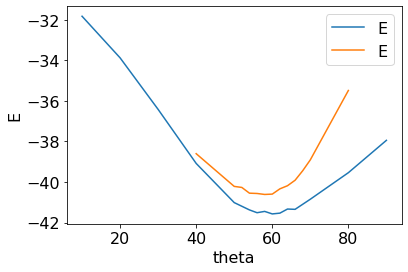

In [6]:
plt.rcParams['font.size']=16
fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_xlabel('theta')
ax.set_ylabel('E')
df_plot_glide_a.plot(ax=ax,label='glide=a')
df_plot_glide_b.plot(ax=ax,label='glide=b')
plt.legend()

# step2

In [3]:
#edge,glideによってt2の計算式変えるべき
calc_2=calc_BTBT()
calc_2.make_csv_step2(glide_mode='b',edge_mode='a')

# step3

In [3]:
calc_3=calc_BTBT()
calc_3.make_csv_step3(glide_mode='b',edge_mode='a')